# ***Living Coasts*** Information and Training <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` environment
* **Products used:** 
[ga_ls_landcover_class_cyear_2](https://explorer.sandbox.dea.ga.gov.au/ga_ls_landcover_class_cyear_2)


## Integrating intertidal, subtidal and other submerged covers

This notebook allows the integration of intertidal and subtidal layers with the classifications of land covers generated through Digital Earth Australa.

In the generation of land cover maps according to the Food and Agriculture Organisation (FAO) Land Cover Classification System (LCCS), the first division in the classification hierarchy is between vegetation and non-vegetation.  In the latter case, all vegetation that is in the intertidal zone and whose canopies are submerged at the highest tides (e.g., sea grasses, macroalgae), these are not classified. Furthermore, many faunal communities (e.g., corals, shellfish, sponges) are not included. 

Hence, **Living Coasts** is developing a new taxonomy that allows for the progressive inclusion of both submerged flora and fauna communities for the intertidal and subtidal zone. However, the classificaiton also considers freshwater environments.

## Description 

This notebook will demonstrate how to load up an area of interest include data layers representing vegetation and faunal communities that are ordinarily submerged.   For this, you will be accessing data extracted for an area near Tully in northern Queensland from the Allen Coral Atlas (https://allencoralatlas.org/) and also a time-series of seagrass extent from Moreton Bay in southeast Queensland, near Brisbane. 

The notebooks take you through the process of:

1. Loading up a shapefile that relates to the area of interest.  
2. Bringing in and resampling raster data from external sources (e.g., Allen Coral Atlas, Seagrass extent).
3. Combining this classification with DEA's land cover product. 
4. Displaying and exporting the combined map. 

If you are new to DEA Land Cover, it is recommended you look at the introductory [DEA Land Cover notebook](../DEA_datasets/DEA_Land_Cover.ipynb) first. 

***

In [1]:
# Initial imports and setup
import sys
import os, re
import datacube
import datetime as dt
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.colors
import matplotlib as mpl
import matplotlib.image as mpimg
import pandas as pd
from matplotlib.colors import ListedColormap
from matplotlib import colormaps
from matplotlib.patches import Patch
from matplotlib import colors as mcolours

import cmocean # for intertidal products
import odc.geo.xr # RML
import pandas as pd
import rioxarray
import rasterio
from rasterio.crs import CRS
import warnings
import xarray as xr
import display_tools
import numpy as np

from datacube.testutils.io import rio_slurp_xarray
from datacube.utils.cog import write_cog
from datacube.utils import masking
from datacube.utils.masking import mask_invalid_data
from datacube.utils.geometry import Geometry
from datetime import datetime, timedelta
from dea_tools.plotting import rgb, display_map, plot_wo, xr_animation 
from dea_tools.datahandling import wofs_fuser, load_ard
from dea_tools.bandindices import calculate_indices
from dea_tools.dask import create_local_dask_cluster
from display_tools import display_da
from ipyleaflet import DrawControl, FullScreenControl, LayersControl, Map, Rectangle, WidgetControl, basemaps, GeoData # Added rectangle RML
from ipywidgets import Button, Dropdown, FloatText, GridspecLayout, Layout, HBox, VBox, Output, Tab, interact, widgets
from IPython.display import HTML, display
from IPython.core.display import Video
from landcover import lc_colourmap, make_colorbar, plot_land_cover
from odc.algo import xr_reproject
from odc.geo.geom import Geometry
from pyproj import CRS, Proj, transform
from rasterio import features
from shapely.geometry import Polygon
from shapely.geometry.polygon import LinearRing
from time import time as time
from wdc_datahandling import geopolygon_masking

warnings.filterwarnings("ignore")

dc = datacube.Datacube()
time_range = None

!pip install openpyxl tqdm

import rioxarray

# Manually invoke garbage collection without printing the result
import gc
import contextlib
with contextlib.redirect_stdout(None):
    gc.collect()

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)




added a new line here
another line


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/34021/status,
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/34021/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35021,Workers: 1
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/34021/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:39817,Total threads: 2
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/37551/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:45249,


## Getting started

To run this analysis, run all the cells in the notebook starting with the 'Load packages and connect to the datacube' cell.

### Load packages

Load key Python packages and supporting functions for the analysis, then connect to the datacube. 

### Connect to the datacube
Connect to the datacube so we can access DEA data. 

In [2]:
dc = datacube.Datacube(app="Land_cover_change_mapping")

### Selecting your study area
This notebook brings in the Allen Coral Atlas using the area around Hinchinbrook Island in Queensland but also other sites, including seagrass data from Moreton Island.

In [3]:
from ipyleaflet import Map, DrawControl, Rectangle, WidgetControl, LayersControl, FullScreenControl, GeoJSON, basemaps
from ipywidgets import Button, VBox, Tab, FloatText, Output, Layout, HBox, HTML, Dropdown
from shapely.geometry import Polygon
import gc
import geopandas as gpd
from ipyfilechooser import FileChooser
import json

# Initialize global variables to store the selected polygon
selected_polygon = None
manual_polygon_layer = None
geojson_layer = None

# Define lat_range and lon_range to avoid NameError in Section 5
lat_range = None
lon_range = None

# Create the map
m = Map(center=[0, 0], zoom=2, basemap=basemaps.Esri.WorldImagery, scroll_wheel_zoom=True, layout=Layout(height='600px'))
m.add_control(LayersControl(position='topright'))
m.add_control(FullScreenControl())

# Output widgets to display coordinates
output_draw = Output(layout={'border': '1px solid black', 'padding': '5px'})
output_manual = Output(layout={'border': '1px solid black', 'padding': '5px'})
output_load = Output(layout={'border': '1px solid black', 'padding': '5px'})

### Draw Method ###
# Setup the draw control with both polygon and rectangle options
draw_control = DrawControl(
    rectangle={"shapeOptions": {"color": "#0000FF"}},
    polygon={"shapeOptions": {"color": "#00FF00"}},
    circlemarker={},
    polyline={},
    circle={}
)
m.add_control(draw_control)

# Event handler for drawing shapes
def handle_draw(target, action, geo_json):
    global selected_polygon, lat_range, lon_range
    output_draw.clear_output()
    coords = geo_json['geometry']['coordinates'][0]
    selected_polygon = Polygon(coords)
    lats, lons = zip(*[(coord[1], coord[0]) for coord in coords])
    lat_range = (min(lats), max(lats))
    lon_range = (min(lons), max(lons))
    with output_draw:
        output_draw.append_stdout("Coordinates:\n")
        output_draw.append_stdout(f"{'Latitude':<20}{'Longitude'}\n")
        for lat, lon in zip(lats, lons):
            output_draw.append_stdout(f"{lat:.6f}\t\t{lon:.6f}\n")

draw_control.on_draw(handle_draw)

# Button to clear drawings and output
clear_button_draw = Button(description='Clear All')

# Event handler for the clear button
def clear_all_draw(b):
    global selected_polygon, lat_range, lon_range
    draw_control.clear()
    output_draw.clear_output()
    selected_polygon = None
    lat_range = None
    lon_range = None
    gc.collect()

clear_button_draw.on_click(clear_all_draw)

draw_tab = VBox([clear_button_draw, output_draw])

### Manual Input Method ###
# Create input widgets for manual coordinate entry
latitude = FloatText(description='Latitude:', layout=Layout(width='100%'))
longitude = FloatText(description='Longitude:', layout=Layout(width='100%'))
buffer = FloatText(description='Buffer (deg):', value=0.1, layout=Layout(width='100%'))
update_button = Button(description='Update Map')

# Function to update the map based on manual input values
def update_map_manual(b):
    global manual_polygon_layer, selected_polygon, lat_range, lon_range
    output_manual.clear_output()
    lat = latitude.value
    lon = longitude.value
    buf = buffer.value
    
    if lat is not None and lon is not None and buf is not None:
        bounds = [[lat - buf, lon - buf], [lat + buf, lon + buf]]
        if manual_polygon_layer:
            m.remove_layer(manual_polygon_layer)
        manual_polygon_layer = Rectangle(bounds=bounds, color="blue", fill_opacity=0.2, weight=2)
        m.add_layer(manual_polygon_layer)
        m.fit_bounds(bounds)
        
        selected_polygon = Polygon([(lon - buf, lat - buf), (lon + buf, lat - buf), (lon + buf, lat + buf), (lon - buf, lat + buf), (lon - buf, lat - buf)])
        lat_range = (lat - buf, lat + buf)
        lon_range = (lon - buf, lon + buf)
        
        with output_manual:
            output_manual.append_stdout("Manual Coordinates:\n")
            output_manual.append_stdout(f"{'Latitude':<20}{'Longitude'}\n")
            output_manual.append_stdout(f"{lat - buf:.6f}\t\t{lon - buf:.6f}\n")
            output_manual.append_stdout(f"{lat - buf:.6f}\t\t{lon + buf:.6f}\n")
            output_manual.append_stdout(f"{lat + buf:.6f}\t\t{lon + buf:.6f}\n")
            output_manual.append_stdout(f"{lat + buf:.6f}\t\t{lon - buf:.6f}\n")
    else:
        with output_manual:
            output_manual.append_stdout("Please fill in all coordinate values.\n")

# Connect the manual update button
update_button.on_click(update_map_manual)

# Button to clear manual input and output
clear_button_manual = Button(description='Clear All')

# Event handler for the clear button
def clear_all_manual(b):
    global selected_polygon, manual_polygon_layer, lat_range, lon_range
    output_manual.clear_output()
    if manual_polygon_layer:
        m.remove_layer(manual_polygon_layer)
    selected_polygon = None
    manual_polygon_layer = None
    lat_range = None
    lon_range = None
    gc.collect()

clear_button_manual.on_click(clear_all_manual)

manual_tab = VBox([latitude, longitude, buffer, update_button, clear_button_manual, output_manual])

### Load Method ###
# File chooser to load shapefile or GeoJSON
file_chooser = FileChooser(filter_pattern=['*.shp', '*.geojson'])
load_button = Button(description='Load File')

# Function to load and display shapefile or GeoJSON
def load_file(b):
    global geojson_layer, selected_polygon, lat_range, lon_range
    output_load.clear_output()
    
    file_path = file_chooser.selected
    
    if file_path:
        if file_path.endswith('.shp'):
            gdf = gpd.read_file(file_path)
            geo_json_data = json.loads(gdf.to_json())
        elif file_path.endswith('.geojson'):
            with open(file_path) as f:
                geo_json_data = json.load(f)
        
        if geojson_layer:
            m.remove_layer(geojson_layer)
        
        geojson_layer = GeoJSON(data=geo_json_data, style={'color': 'green', 'fillOpacity': 0.5})
        m.add_layer(geojson_layer)
        
        coords = geo_json_data['features'][0]['geometry']['coordinates'][0]
        selected_polygon = Polygon(coords)
        lats, lons = zip(*[(coord[1], coord[0]) for coord in coords])
        lat_range = (min(lats), max(lats))
        lon_range = (min(lons), max(lons))
        
        m.fit_bounds([[min(lats), min(lons)], [max(lats), max(lons)]])
        
        with output_load:
            output_load.append_stdout(f"Loaded {file_path}\n")
            output_load.append_stdout("Coordinates:\n")
            output_load.append_stdout(f"{'Latitude':<20}{'Longitude'}\n")
            for lat, lon in zip(lats, lons):
                output_load.append_stdout(f"{lat:.6f}\t\t{lon:.6f}\n")
    else:
        with output_load:
            output_load.append_stdout("Please select a file.\n")

load_button.on_click(load_file)

# Load method tab layout
load_tab = VBox([file_chooser, load_button, output_load])

### Main Method Selection Tab ###
# Add all tabs to the main method selection tab
method_tab = Tab()
method_tab.children = [draw_tab, manual_tab, load_tab]
method_tab.set_title(0, 'Draw Method')
method_tab.set_title(1, 'Manual Input Method')
method_tab.set_title(2, 'Load Method')

# Add the method selection tab control to the map
method_control = WidgetControl(widget=method_tab, position='topright')
m.add_control(method_control)

# Create a subtle tab for collapsing/expanding the menu using Button
collapse_button = Button(description=">", layout=Layout(width='30px', height='30px'))

# Event handler for the collapse/expand button
def toggle_collapse(b):
    if method_control in m.controls:
        m.remove_control(method_control)
        collapse_button.description = "<"
    else:
        m.add_control(method_control)
        collapse_button.description = ">"

collapse_button.on_click(toggle_collapse)

# Add the collapse button to the map
collapse_control = WidgetControl(widget=collapse_button, position='topright')
m.add_control(collapse_control)

# Display the map
display(m)

print("Draw, Manual Input, and Load methods setup with menu toggle completed.")

# Manually invoke garbage collection
gc.collect()

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

Draw, Manual Input, and Load methods setup with menu toggle completed.


0

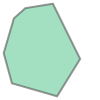

In [5]:
selected_polygon

In [6]:
gdf = gpd.GeoDataFrame({'geometry': [selected_polygon]}, crs="EPSG:4326")

In [7]:
from datetime import datetime
from IPython.display import display
from ipywidgets import widgets

# Input widgets for specifying the year range
start_date_input = widgets.DatePicker(
    description="Start Date", value=datetime(2010, 1, 1)  # Default value (example)
)

end_date_input = widgets.DatePicker(
    description="End Date", value=datetime(2020, 12, 31)  # Default value (example)
)

# Display date pickers
display(start_date_input, end_date_input)

# Update the global variables with the selected time range
def update_time_range(change):
    global time_range
    start_date = start_date_input.value
    end_date = end_date_input.value
    time_range = (start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))
    print(f"Selected time range: {time_range}")

# Attach the update function to the date pickers
start_date_input.observe(update_time_range, names='value')
end_date_input.observe(update_time_range, names='value')

# Initial call to set the time range
update_time_range(None)

DatePicker(value=datetime.datetime(2010, 1, 1, 0, 0), description='Start Date', step=1)

DatePicker(value=datetime.datetime(2020, 12, 31, 0, 0), description='End Date', step=1)

Selected time range: ('2010-01-01', '2020-12-31')


In [8]:
# Section 5: Load Data from Datacube

# Step 1: Check if required variables are defined
if lat_range is None or lon_range is None or start_date_input.value is None or end_date_input.value is None:
    raise ValueError("Latitude, Longitude, or Time range is not defined")

print("Lat Range:", lat_range)
print("Lon Range:", lon_range)
print("Start Date:", start_date_input.value)
print("End Date:", end_date_input.value)

# Step 2: Construct the query
query = {
    "y": lat_range,
    "x": lon_range,
    "time": (start_date_input.value, end_date_input.value),
}

print("Query Parameters:", query)

# Step 3: Load DEA Land Cover data from the datacube
try:
    lc = dc.load(
        product="ga_ls_landcover_class_cyear_2",
        output_crs="EPSG:3577",
        measurements=[
            "level3",
            "lifeform",
            "vegetation_cover",
            "water_seasonality",
            "water_state",
            "intertidal",
            "water_persistence",
            "bare_gradation",
            "full_classification",
        ],
        resolution=(-25, 25),
        **query
    )
    print("Data loaded successfully.")
except Exception as e:
    raise RuntimeError(f"Error loading data from the datacube: {e}")

# Step 4: Check if the dataset is loaded correctly
if lc is None or lc.geobox is None:
    raise ValueError("Failed to load the dataset. Please check the query parameters and ensure data is available for the specified region and time range.")   
    
# Step 5: Print geobox information
geobox = lc.geobox

geobox_info = f"""
Geobox Information:
-------------------
CRS: {geobox.crs}
Dimensions: {geobox.dimensions}
Resolution: {geobox.resolution}
Shape: {geobox.shape}
Extent: {geobox.extent}
"""

print(geobox_info)

# Step 6: Check loaded data dimensions and variables
print("Loaded data dimensions:", lc.dims)
print("Loaded data variables:", lc.data_vars)


Lat Range: (-27.46776, -27.302227)
Lon Range: (153.341262, 153.477904)
Start Date: 2010-01-01 00:00:00
End Date: 2020-12-31 00:00:00
Query Parameters: {'y': (-27.46776, -27.302227), 'x': (153.341262, 153.477904), 'time': (datetime.datetime(2010, 1, 1, 0, 0), datetime.datetime(2020, 12, 31, 0, 0))}
Data loaded successfully.

Geobox Information:
-------------------
CRS: PROJCS["GDA94 / Australian Albers",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",132],PARAMETER["standard_parallel_1",-18],PARAMETER["standard_parallel_2",-36],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["

In [9]:
# Load and mask the Intertidal Elevation products (select measurement = elevation, elevation_uncertainty and exposure)
item = dc.load(
    product="ga_s2ls_intertidal_cyear_3", like=lc)

item = mask_invalid_data(item)
item = item.where(item!=0)

bounds = np.array([10, 10, 40, 40])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=100)
print(norm([10,40]))

2024-08-20 15:31:20,745 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2024-08-20 15:31:22,823 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2024-08-20 15:31:25,222 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2024-08-20 15:31:27,834 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2024-08-20 15:31:30,109 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2024-08-20 15:31:31,888 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2024-08-20 15:31:34,009 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2024-08-20 15:31:36,251 - distributed.utils_perf - WARNING - full garbage collections took

[49 100]


In [10]:
# Section 6: Checkbox widgets for selecting datasets
level3_checkbox = widgets.Checkbox(description='Level 3', value=False)
lifeform_checkbox = widgets.Checkbox(description='Lifeform', value=False)
vegetation_cover_checkbox = widgets.Checkbox(description='Vegetation Cover', value=False)
water_state_checkbox = widgets.Checkbox(description='Water State', value=False)
water_persistence_checkbox = widgets.Checkbox(description='Water Persistence', value=False)
full_classification_checkbox = widgets.Checkbox(description='Full Classification', value=False)
item_checkbox = widgets.Checkbox(description='Intertidal Elevation', value=False)

output = widgets.Output()

def plot_selected_datasets():
    with output:
        output.clear_output()
        selected_datasets = []
        if level3_checkbox.value:
            selected_datasets.append('level3')
        if lifeform_checkbox.value:
            selected_datasets.append('lifeform')
        if vegetation_cover_checkbox.value:
            selected_datasets.append('vegetation_cover')
        if water_state_checkbox.value:
            selected_datasets.append('water_state')
        if water_persistence_checkbox.value:
            selected_datasets.append('water_persistence')            
        if full_classification_checkbox.value:
            selected_datasets.append('full_classification')
        if item_checkbox.value:
            selected_datasets.append('item')

        for dataset in selected_datasets:
            plt.figure()
            if dataset == 'level3':
                plot_land_cover(lc.level3)
            elif dataset == 'lifeform':
                plot_land_cover(lc.lifeform)
            elif dataset == 'vegetation_cover':
                plot_land_cover(lc.vegetation_cover)
            elif dataset == 'water_state':
                plot_land_cover(lc.water_state)
            elif dataset == 'water_persistence':
                plot_land_cover(lc.water_persistence)
            elif dataset == 'full_classification':
                plot_land_cover(lc.full_classification)
            elif dataset == 'item':
                plot_land_cover(item.elevation[0])
            plt.show()

plot_datasets_button = widgets.Button(description='Plot Selected Data')
plot_datasets_button.on_click(lambda b: plot_selected_datasets())

checkboxes_box = widgets.HBox([
    level3_checkbox, 
    lifeform_checkbox, 
    vegetation_cover_checkbox, 
    water_state_checkbox, 
    water_persistence_checkbox, 
    full_classification_checkbox,
    item_checkbox
])
display(checkboxes_box)
display(plot_datasets_button)
display(output)

Button(description='Plot Selected Data', style=ButtonStyle())

Output()

#### Integrating marine layers
Loading each layer and setting no data to 'Nan'

2024-08-20 15:32:07,206 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)


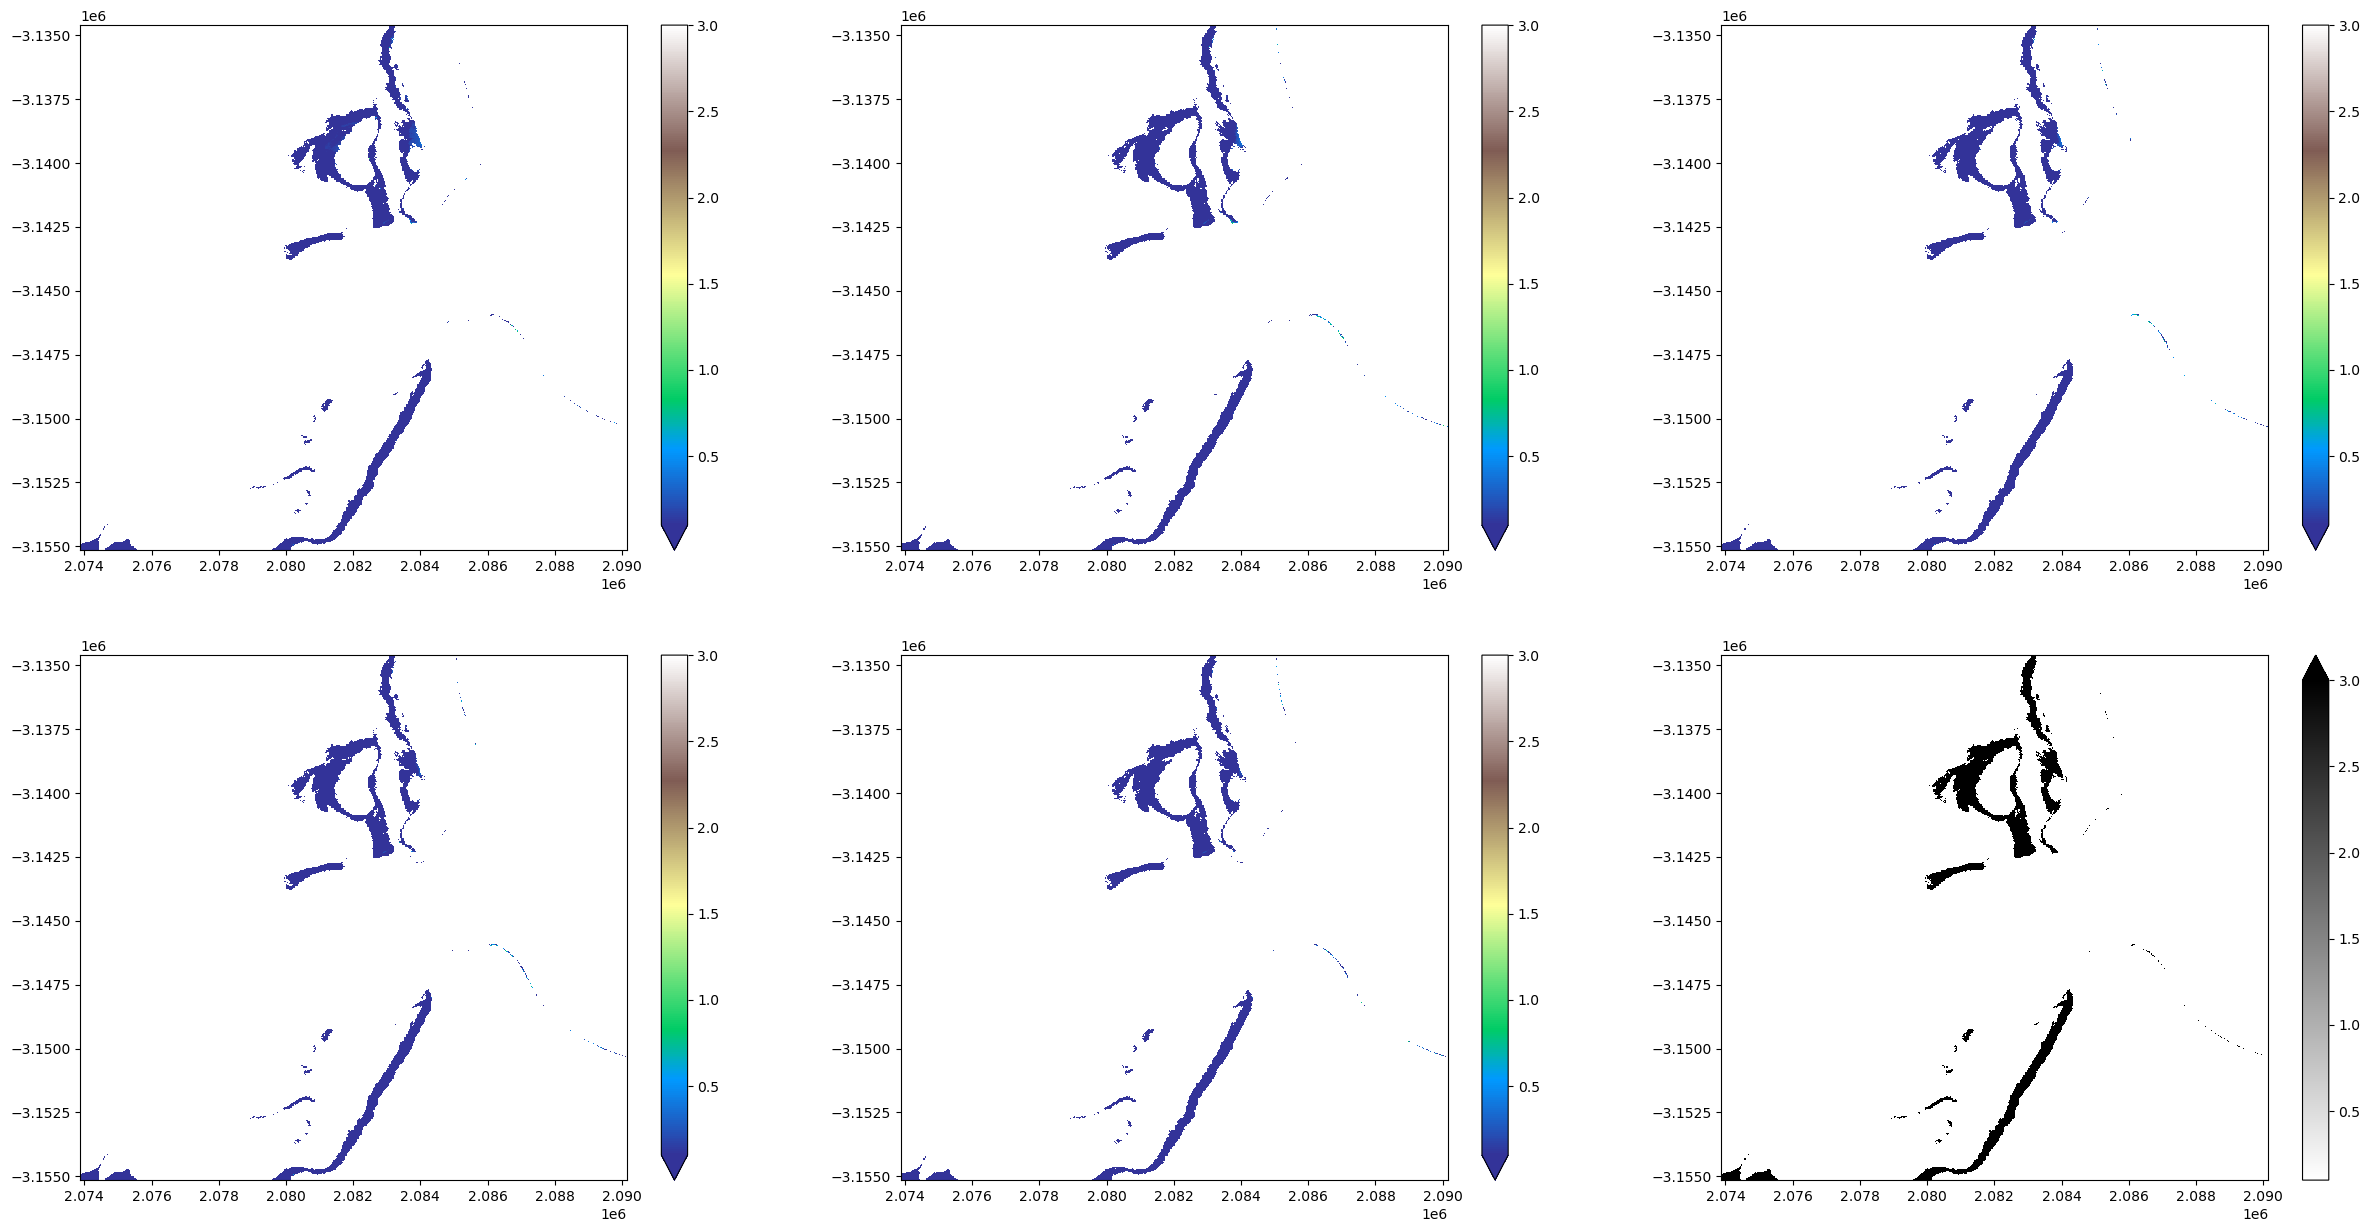

In [11]:
item_fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(30, 15))
item.elevation[0].where(lc.intertidal[0]!=0).plot(ax=axs[0,0], vmin = 0.1, vmax = 3, add_labels=False, cmap='terrain')
item.elevation[1].where(lc.intertidal[0]!=0).plot(ax=axs[0,1], vmin = 0.1, vmax = 3, add_labels=False, cmap='terrain')
item.elevation[2].where(lc.intertidal[0]!=0).plot(ax=axs[0,2], vmin = 0.1, vmax = 3, add_labels=False, cmap='terrain')
item.elevation[3].where(lc.intertidal[0]!=0).plot(ax=axs[1,0], vmin = 0.1, vmax = 3, add_labels=False, cmap='terrain')
item.elevation[4].where(lc.intertidal[0]!=0).plot(ax=axs[1,1], vmin = 0.1, vmax = 3, add_labels=False, cmap='terrain')
item.exposure[0].where(lc.intertidal[0]!=0).plot(ax=axs[1,2], vmin = 0.1, vmax = 3, add_labels=False, cmap='binary')

In [12]:
display_tools.display_da(lc.intertidal[4].where((lc.intertidal[4] >0 )&(lc.intertidal[4] < 5)), colormap='terrain_r')

Map(center=[-27.385041272980402, 153.4097141842021], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [13]:
# Saltmarsh 
#Saltmarsh = "uploads/marine/Tully_Saltmarsh_ll.tif"
Saltmarsh = "uploads/marine/MB_saltmarsh_cz.tif"
raster = rioxarray.open_rasterio(Saltmarsh).squeeze("band", drop=True)
Saltmarsh_prj = rio_slurp_xarray(Saltmarsh,
                                      lc.geobox,
                                      resampling="nearest")
Saltmarsh_prj = mask_invalid_data(Saltmarsh_prj)

In [ ]:
# Macroalgae Mats
MacroalgaeMats = "uploads/marine/Tully_MacroalgaeMats_ll.tif"
raster = rioxarray.open_rasterio(MacroalgaeMats).squeeze("band", drop=True)
MacroalgaeMats_prj = rio_slurp_xarray(MacroalgaeMats,
                                      lc.geobox,
                                      resampling="nearest")
MacroalgaeMats_prj = mask_invalid_data(MacroalgaeMats_prj)

In [ ]:
# Rock
Rock = "uploads/marine/Tully_Rock_ll.tif"
raster = rioxarray.open_rasterio(Rock).squeeze("band", drop=True)
Rock_prj = rio_slurp_xarray(Rock,
                                      lc.geobox,
                                      resampling="nearest")
Rock_prj = mask_invalid_data(Rock_prj)

In [14]:
# Sand
#Sand = "uploads/marine/Tully_Sand_ll.tif"
Sand = "uploads/marine/MB_tidalflat_cz.tif"
raster = rioxarray.open_rasterio(Sand).squeeze("band", drop=True)
Sand_prj = rio_slurp_xarray(Sand,
                                      lc.geobox,
                                      resampling="nearest")
Sand_prj = mask_invalid_data(Sand_prj)

In [ ]:
# Saltflat 
Saltflat = "uploads/marine/Tully_Saltflat_ll.tif"
raster = rioxarray.open_rasterio(Saltflat).squeeze("band", drop=True)
Saltflat_prj = rio_slurp_xarray(Saltflat,
                                      lc.geobox,
                                      resampling="nearest")
Saltflat_prj = mask_invalid_data(Saltflat_prj)

In [ ]:
# Rubble
Rubble = "uploads/marine/Tully_Rubble_ll.tif"
raster = rioxarray.open_rasterio(Rubble).squeeze("band", drop=True)
Rubble_prj = rio_slurp_xarray(Rubble,
                                      lc.geobox,
                                      resampling="nearest")
Rubble_prj = mask_invalid_data(Rubble_prj)

In [15]:
# Seagrass
#Seagrass = "uploads/Tully_Seagrass_ll.tif"
Seagrass = "uploads/marine/MB_seagrass_2021.tif"

raster = rioxarray.open_rasterio(Seagrass).squeeze("band", drop=True)
Seagrass_prj = rio_slurp_xarray(Seagrass,
                                      lc.geobox,
                                      resampling="nearest")
Seagrass_prj = mask_invalid_data(Seagrass_prj)

In [16]:
# Coral/algae
#Coral_Algae = "uploads/Tully_Coral_Algae_ll.tif"
#Coral_Algae = "uploads/marine/MB_seagrass_2021.tif"
Coral_Algae = "uploads/marine/MB_intertidal_seagrass_cz.tif"
raster = rioxarray.open_rasterio(Coral_Algae).squeeze("band", drop=True)
Coral_Algae_prj = rio_slurp_xarray(Coral_Algae,
                                      lc.geobox,
                                      resampling="nearest")
Coral_Algae_prj = mask_invalid_data(Coral_Algae_prj)

### Tully

In [ ]:
Aquatic = Saltmarsh_prj.to_dataset(name="Saltmarsh")
Aquatic["MacroalgaeMats"] = MacroalgaeMats_prj
Aquatic["Rock"] = Rock_prj
Aquatic["Sand"] = Sand_prj
Aquatic["Rubble"] = Rubble_prj
Aquatic["Saltflat"] = Saltflat_prj
Aquatic["Seagrass"] = Seagrass_prj
Aquatic["Coral_Algae"] = Coral_Algae_prj
Aquatic["Sum"]= lc.level3.isel(time=4) + ((Aquatic.Rubble)+4) + ((Aquatic.Sand)+102) + ((Aquatic.Rock)+103) + ((Aquatic.Saltflat)+104) + ((Aquatic.Saltmarsh)+105) + ((Aquatic.Seagrass)+106) + ((Aquatic.Coral_Algae)+107)    

### Moreton Bay

In [17]:
Aquatic = Saltmarsh_prj.to_dataset(name="Saltmarsh")
Aquatic["Sand"] = Sand_prj
Aquatic["Seagrass"] = Seagrass_prj
Aquatic["Coral_Algae"] = Coral_Algae_prj
Aquatic["Elevation"] = lc.intertidal[4].where((lc.intertidal[4] >0 )&(lc.intertidal[4] < 5))

#Aquatic["Sum"]= lc.level3.isel(time=4) + ((Aquatic.Seagrass)+106) 
#Aquatic["Sum"]= lc.level3.isel(time=4) + ((Aquatic.Rubble)+4) + ((Aquatic.Sand)+102) + ((Aquatic.Rock)+103) + ((Aquatic.Saltflat)+104) + ((Aquatic.Saltmarsh)+105) + ((Aquatic.Seagrass)+106) + ((Aquatic.Coral_Algae)+107) 
Aquatic["Sum"]= lc.level3.isel(time=4) + ((Aquatic.Sand)+102) + ((Aquatic.Elevation)+103) + ((Aquatic.Saltmarsh)+105) + ((Aquatic.Seagrass)+106) + ((Aquatic.Coral_Algae)+107)    

In [18]:
# Loop through polygons in geodataframe and extract satellite data
for index, row in gdf.iterrows():

    print(f'Feature: {index + 1}/{len(gdf)}')

    # Extract the feature's geometry as a datacube geometry object
    geom = Geometry(geom=row.geometry, crs=gdf.crs)

    # Update the query to include our geopolygon
    query.update({'geopolygon': geom})

    # Mask dataset to set pixels outside the polygon to `NaN`
    Aquatic_masked = Aquatic.odc.mask(poly=geom)


Feature: 1/1


In [19]:
Aquatic = Aquatic.fillna(0)

In [20]:
#del Saltmarsh_prj, MacroalgaeMats_prj, Rock_prj, Sand_prj, Rubble_prj, Saltflat_prj, Seagrass_prj, Coral_Algae_prj

In [21]:
#LCCS_Aquatic = lc.full_classification.isel(time=4) + ((Aquatic.Seagrass)*9)
LCCS_Aquatic = lc.full_classification.isel(time=4) + ((Aquatic.Sand)*5) + ((Aquatic.Elevation)*6) +((Aquatic.Saltmarsh)*8) + ((Aquatic.Seagrass)*9) + ((Aquatic.Coral_Algae)*10)  

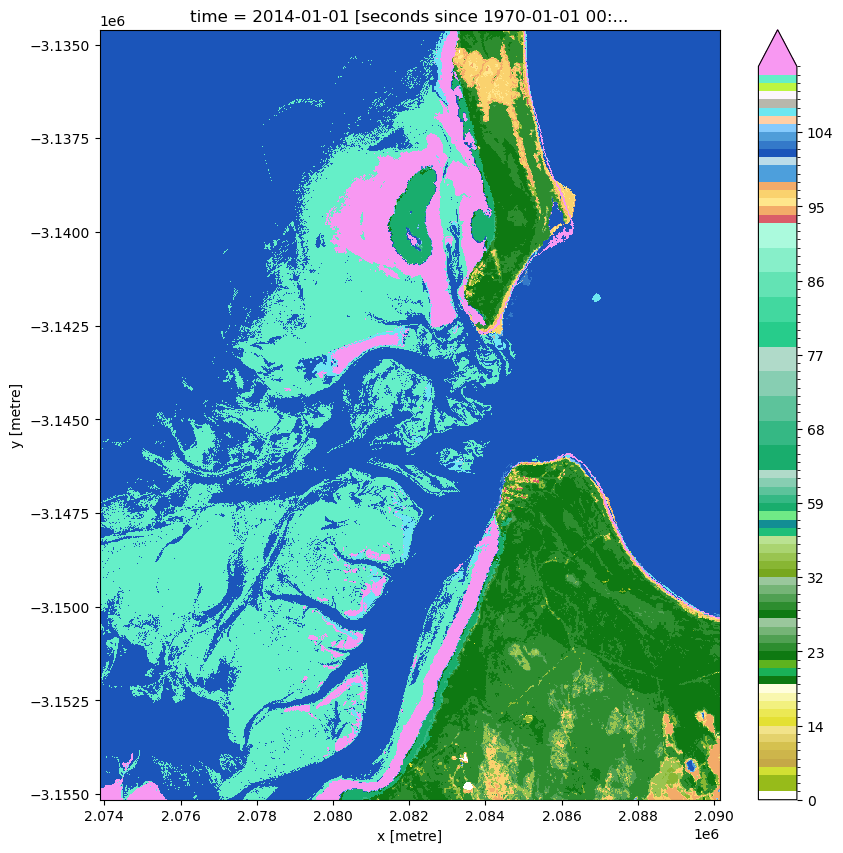

In [22]:
cmap, norm = lc_colourmap('level4')
LCCS_Aquatic.plot(figsize=(10, 10), cmap=cmap, norm=norm)

### Exporting to Geotiff
At the end of an analysis it can be useful to export data to a GeoTIFF file (e.g. `outputname.tif`), either to save results or to allow for exploring results in a GIS software platform (e.g. ArcGIS or QGIS).

A `Cloud Optimized GeoTIFF` (COG) is a regular GeoTIFF file (i.e. that can be opened by GIS software like QGIS or ArcMap) aimed at being hosted on a HTTP file server, with an internal organization that enables more efficient workflows on the cloud.

This method uses the datacube.utils.cog function write_cog (where COG stands for Cloud Optimised GeoTIFF) 
to export a simple single-band, single time-slice GeoTIFF file. A few important caveats should be noted when using this function.  It requires an xarray.DataArray; not supplying an xarray.Dataset will return an error.

In [ ]:
# Write GeoTIFF to a location
write_cog(geo_im=LCCS_Aquatic,
          fname='outputs/LCCS_Aquatic',
          overwrite=True)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** February 2022

**Compatible datacube version:** 

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)